In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
import numpy as np
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length
from sklearn.metrics import auc

from torch.autograd import Variable

import numpy as np
import pandas as pd

from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

from numpy import asarray
from numpy import savez_compressed
def uplift_curve(y_true, uplift, treatment):
   

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):
  

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
   

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

In [ ]:
!git clone https://github.com/pianonyy/UPLIFT_modeling.git

Cloning into 'UPLIFT_modeling'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 567 (delta 153), reused 192 (delta 74), pack-reused 266
Receiving objects: 100% (567/567), 13.66 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (265/265), done.


In [ ]:
!pip install -e UPLIFT_modeling/

Obtaining file:///content/UPLIFT_modeling
  Running setup.py develop for uplift


In [ ]:
df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')

indices_train, indices_test = train_test_split(
         df_train_feats.index,
         test_size=0.3,
         random_state = 13
)


treatment_train = df_train_feats.loc[indices_train,'treatment_flg']
y_train = df_train_feats.loc[indices_train,'target']


treatment_test = df_train_feats.loc[indices_test,'treatment_flg']
y_test = df_train_feats.loc[indices_test,'target']

df_train_feats = df_train_feats.drop(
            ['treatment_flg', 'target'], 
            axis=1
)

df_train_feats = df_train_feats.replace([np.inf, -np.inf], np.nan).fillna(0)

x_train = df_train_feats.loc[indices_train]
x_test = df_train_feats.loc[indices_test]


print("train shape:", x_train.shape)
print("test shape:", x_test.shape)

train shape: (140027, 6)
test shape: (60012, 6)


In [ ]:
all = pd.DataFrame({
    "treatment":treatment_train,
    "target": y_train
})
all['Z_trans'] = 0

all.loc[(all['target'] == 1) & (all['treatment'] == 1),'Z_trans'] = 2
all.loc[(all['target'] == 1) & (all['treatment'] == 0),'Z_trans'] =  -2
all.loc[all['Z_trans'].isnull(), 'Z_trans'] = 0

Z_trans_train = all['Z_trans']

all = pd.DataFrame({
    "treatment":treatment_test,
    "target": y_test
})
all['Z_trans'] = 0

all.loc[(all['target'] == 1) & (all['treatment'] == 1),'Z_trans'] = 2
all.loc[(all['target'] == 1) & (all['treatment'] == 0),'Z_trans'] =  -2
all.loc[all['Z_trans'].isnull(), 'Z_trans'] = 0

Z_trans_test = all['Z_trans']

In [ ]:
from sklearn.preprocessing import StandardScaler 
import numpy as np


scaler = StandardScaler(with_std = True, with_mean = True)

X_train_0 = x_train.copy()


X_train_1 = x_train.copy()


X_train_1 = X_train_1.astype('float32')
X_train_1 = X_train_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_1 = scaler.fit_transform(X_train_1)

X_train_0 = X_train_0.astype('float32')
X_train_0 = X_train_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_train_0 = scaler.fit_transform(X_train_0)


X_test_0 = x_test.copy()


X_test_1 = x_test.copy()


X_test_1 = X_test_1.astype('float32')
X_test_1 = X_test_1.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_1 = scaler.fit_transform(X_test_1)

X_test_0 = X_test_0.astype('float32')
X_test_0 = X_test_0.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_0 = scaler.fit_transform(X_test_0)

X_test_0 = np.c_[ X_test_0, np.zeros(X_test_0.shape[0]) ]
X_test_1 = np.c_[ X_test_1, np.ones(X_test_1.shape[0]) ] 

X_train_0 = np.c_[ X_train_0, np.zeros(X_train_0.shape[0]) ]
X_train_1 = np.c_[ X_train_1, np.ones(X_train_1.shape[0]) ]

In [ ]:
print(X_train_0.shape)
print(X_train_1.shape)
print(Z_trans_train.shape)
print(treatment_train.shape)
print(y_test.shape)

(140027, 7)
(140027, 7)
(140027,)
(140027,)
(60012,)


In [ ]:
class trainData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment, y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)


train_data = trainData(torch.FloatTensor(X_train_0),torch.FloatTensor(X_train_1),torch.FloatTensor(Z_trans_train.values),torch.FloatTensor(treatment_train.values), 
                       torch.FloatTensor(y_train.values))
## test data    

class testData(Dataset):
    
    def __init__(self, X_data_0,X_data_1,Z_trans,treatment,y_data):
        self.X_data_0 = X_data_0
        self.X_data_1 = X_data_1
        self.Z_trans = Z_trans
        self.treatment = treatment
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data_0[index], self.X_data_1[index],self.Z_trans[index], self.treatment[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data_0)
    

test_data = testData(torch.FloatTensor(X_test_0),torch.FloatTensor(X_test_1), torch.FloatTensor(Z_trans_test),torch.FloatTensor(treatment_test), 
                       torch.FloatTensor(y_test))

.......................... epoch = 0 ..........................
work with test dataset
.......................... epoch = 1 ..........................
work with test dataset
.......................... epoch = 2 ..........................
work with test dataset
.......................... epoch = 3 ..........................
work with test dataset
.......................... epoch = 4 ..........................
work with test dataset
.......................... epoch = 5 ..........................
work with test dataset
.......................... epoch = 6 ..........................
work with test dataset
.......................... epoch = 7 ..........................
work with test dataset
.......................... epoch = 8 ..........................
work with test dataset
.......................... epoch = 9 ..........................
work with test dataset
.......................... epoch = 10 ..........................
work with test dataset
.......................... epoch = 11 ....

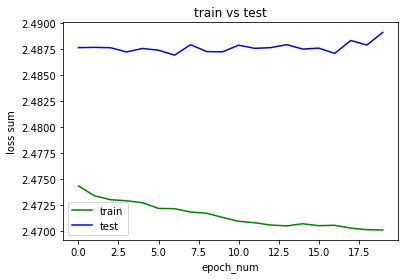

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 31 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60012 


epoch_num = 20  # Number of epochs to train the network
lr = 0.001        # Learning rate


#140000 - train
#60011 - test

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(7, 6)
        self.fc2 = nn.Linear(6, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
        
#         self.fc1 = nn.Linear(334, 290)
#         self.fc2 = nn.Linear(290, 210)
#         self.fc3 = nn.Linear(210, 170)
#         self.fc4 = nn.Linear(170, 130)
#         self.fc5 = nn.Linear(130, 90)
#         self.fc6 = nn.Linear(90, 10)
#         self.fc7 = nn.Linear(10, 1)


#         # # ...
#         # self.fc2 = nn.Linear(200, 100)


#         # self.fc3 = nn.Linear(100, 1) # conv1d??

#     def forward(self, x):
        
#         x = F.relu(self.fc1(x))  #leaky_relu ???
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))  #leaky_relu ???
#         x = F.relu(self.fc4(x))
#         x = F.relu(self.fc5(x))  #leaky_relu ???
#         x = F.relu(self.fc6(x))
#         x = self.fc7(x)
#         m = nn.Sigmoid()
#         return m(x)
        

# class Model(nn.Module):
#     def __init__(self): 
#         super(Model, self).__init__()
#         self.classifier = nn.Sequential(
#             nn.Linear(334, 200),
#             nn.BatchNorm1d(200), #applying batch norm
#             nn.ReLU(),
#             nn.Linear(200, 100),
#             nn.BatchNorm1d(100),
#             nn.ReLU(),
#             nn.Linear(100, 1)
#         )
             
#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         m = nn.Sigmoid()
#         return m(x)
#         # return x

model = Model()
alpha = 0.0

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# print(model)


# #convert to torch structure
# X_test_1_tensor = torch.FloatTensor(X_test_1) 
# X_test_0_tensor = torch.FloatTensor(X_test_0)


# #convert to torch structure
# treatment_test = treatment_test.to_numpy()
# treatment_test = torch.from_numpy(treatment_test).int()
# treatment_test = Variable(treatment_test)


# #convert to torch structure
# y_test = y_test.to_numpy()
# y_test = torch.from_numpy(y_test).float()
# y_test  = Variable(y_test)


# #convert to torch structure
# Z_trans_test = Z_trans_test.to_numpy()
# Z_trans_test = torch.from_numpy(Z_trans_test).float()
# Z_trans_test = Variable(Z_trans_test)


#init loaders
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)




# define the loss (criterion) and create an optimizer
optimizer = optim.Adam(model.parameters(),lr = lr)

# sgd??   

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []



# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in train_loader:
       
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
        

        
      

        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        

        
       

       
        
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
        
        
        # print("uplift_pred", uplift_pred)

        

        

        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        # print(loss_contrastive)
        batch_loss.append(sum_of_losses)
        # print("train AUQC:", qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        # Backward pass and updates
        sum_of_losses.backward()                     # calculate the gradients
        optimizer.step()                    # update the weights
        # i += batch_size
        #end for !!!!!!!!!!!!!!!!!!!

    # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
    # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []

   
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
       
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        # optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

       
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        # print("mu_0", mu_0_target_class)
        # print("mu_1", mu_1_target_class)

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
        
     
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        # print(batch_n, loss_contrastive)


        # plot_qini_curve(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy())
        # print(qini_auc_score(batch_label.cpu().detach().numpy(), uplift_pred.cpu().detach().numpy(), treatment_batch.cpu().detach().numpy() ))
        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

    
   

import matplotlib.pyplot as plt

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')



plt.plot(test_losses, color='blue',label='test')
plt.legend()


plt.show()





In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []
df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.7333333333333333 with p_

In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

In [ ]:
from UPLIFT_modeling.uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []
df_train_feats = pd.read_csv("/content/drive/MyDrive/retail_hero_final_model_train_data.csv", index_col = 'client_id')
for j in range( 1, 101, 1):

    #logger.info(f"Random state =:{j}")
    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        indices_test,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = x_test.loc[indices_valid_new, :]
    treatment_valid = df_train_feats.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = df_train_feats.loc[indices_valid_new, 'target'].values

    X_valid_0 = X_valid.copy()
    X_valid_1 = X_valid.copy()

    X_valid_1 = X_valid_1.astype('float32')
    X_valid_1 = X_valid_1.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_1 = scaler.fit_transform(X_valid_1)

    X_valid_0 = X_valid_0.astype('float32')
    X_valid_0 = X_valid_0.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_valid_0 = scaler.fit_transform(X_valid_0)

    X_valid_0 = np.c_[ X_valid_0, np.zeros(X_valid_0.shape[0]) ]
    X_valid_1 = np.c_[ X_valid_1, np.ones(X_valid_1.shape[0]) ] 

    model.eval()
    X_valid_1 = torch.FloatTensor(X_valid_1)
    X_valid_0 = torch.FloatTensor(X_valid_0)
    
    mu_1 = model(X_valid_1)
    mu_0 = model(X_valid_0)
    valid_pred = mu_1-mu_0
    
    valid_pred = valid_pred.detach().numpy()
    valid_pred = valid_pred.reshape((-1,)) 
  
    valid_pred = pd.Series(valid_pred, index = indices_valid_new)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank